# 23.2 MARL (MADDPG)
> 前文已经介绍了 **多智能体强化学习的基本求解范式：完全中心化 与 完全去中心化**。本节来介绍一种比较经典且效果不错的**进阶范式：中心化训练去中心化执行（centralized training with decentralized execution，CTDE）**：
> - **中心化训练**：在训练的时候使用一些单个智能体看不到的 **全局信息** 而以达到更好的训练效果。
> - **去中心化执行**：在执行时不使用 **全局信息**，每个智能体完全根据自己的策略执行动作。

**CTDE** 可以类比成一个足球队的训练和比赛过程：在训练时，11 个球员可以直接获得教练的指导从而完成球队的整体配合，而教练本身掌握着比赛全局信息，教练的指导也是从整支队、整场比赛的角度进行的；而训练好的 11 个球员在上场比赛时，则根据场上的实时情况直接做出决策，不再有教练的指导。
> 所以 **CTDE** 能够在训练时有效地利用全局信息以达到 **更好且更稳定的训练效果**，同时在进行策略模型推断时可以仅利用局部信息，使得算法**具有一定的扩展性**。

> **CTDE** 算法主要分为两种：
> - 一种是基于值函数的方法，例如 **VDN，QMIX** 
> - 一种是基于 Actor-Critic 的方法，例如 **MADDPG，COMA** 

> 本节介绍 **MADDPG** 算法 （[Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/abs/1706.02275)）

## 23.2.1 MADDPG 算法原理
- 学习本节内容之前，可以先复习之前的 [DDPG 算法](../RL_Classic_Algorithms/16.DDPG(Pendulum-v1).ipynb) ，**Actor**梯度为：
$$\nabla_\theta J(\mu_\theta)=\mathbb{E}_{s\sim\nu^{\pi_\beta}}
\begin{bmatrix}
\nabla_\theta\mu_\theta(s)\nabla_aQ_\omega^{\mu_\theta}(s,a)|_{a=\mu_\theta(s)}
\end{bmatrix}$$
> 与 **‘纯DDPG’** 不同，在 **MADDPG** 中 **所有智能体共享一个中心化的 Critic 网络**，该 Critic 网络在训练的过程中同时对每个智能体的 Actor 网络给出指导；而执行时，**每个智能体的 Actor 网络** 则是完全独立做出行动，即去中心化地执行：

> ![Overview_of_MADDPG_AC](./Illustrations/Overview_of_MADDPG_AC.png)

考虑现在有$N$个连续的策略$\mu_{\theta_i}$，**Actor**梯度公式变为：
$$\nabla_{\theta_i}J(\mu_i)=\mathbb{E}_{\mathbf{x}\sim\mathcal{D}}[\nabla_{\theta_i}\mu_i(o_i)\nabla_{a_i}Q_i^\mu(\mathbf{x},a_1,\ldots,a_N)|_{a_i=\mu_i(o_i)}]$$
- 对于每个智能体 $i$，其动作空间为$A_i$，观测空间为$O_i$
- $\mathbf{x}=(o_{1},\ldots,o_{N})$ 包含了所有智能体的观测
- $\mathcal{D}$ 表示存储数据的经验回放池，它存储的每一个数据为 $(\mathbf{x},\mathbf{x}^{\prime},a_1,\ldots,a_N,r_1,\ldots,r_N)$
- 可见，有一个 **Critic** $Q_w$，$N$个 **Actor** $\mu_\theta^i$

此时在 **MADDPG** 中，**中心化的动作价值网络$Q$** 更新的损失函数变为：
$$\mathcal{L}(\omega_i)=\mathbb{E}_{\mathbf{x},a,r,\mathbf{x}^{\prime}}[(Q_i^\mu(\mathbf{x},a_1,\ldots,a_N)-y)^2]$$
$$y=r_i+\gamma Q_i^{\mu^{\prime}}(\mathbf{x}^{\prime},a_1^{\prime},\ldots,a_N^{\prime})|_{a_j^{\prime}=\mu_j^{\prime}(o_j)}$$

## 23.2.2 MADDPG 代码实践

导入基本库

In [34]:
import numpy as np
from utils.replay_buffer import ReplayBuffer

import torch
import torch.nn.functional as F

### 1. 关于环境库
同样需新建一个虚拟环境（防止软件包冲突），下载 **MPE2库**（[使用文档](https://mpe2.farama.org/environments/simple_adversary/)），使用其中的 **多智能体粒子环境（multiagent particles environment，MPE）**：
(如果图片加载异常，请在浏览器中打开 Notebook)
![mpe2_simple_adversary](./Illustrations/simple_adversary.gif)

- 该环境中有 1 个红色的对抗智能体（adversary）、$N$ 个蓝色的正常智能体，以及 $N$ 个地点（一般 $N=2$）
- 每个智能体的观察空间都为其他智能体的位置以及地点的位置
- $N$ 个地点中有一个是目标地点（绿色），正常智能体知道哪一个是目标地点，但对抗智能体不知道
- 正常智能体是合作关系：它们其中任意一个距离目标地点足够近，则每个正常智能体都能获得相同的奖励
- 对抗智能体如果距离目标地点足够近，也能获得奖励，但它需要猜哪一个才是目标地点

因此，性能好的正常智能体会趋于分散到不同的坐标点，以此欺骗对抗智能体。

***测试（两个版本）：***

In [35]:
from mpe2 import simple_adversary_v3

In [71]:
# 逐个循环智能体
env = simple_adversary_v3.env(N=2, max_cycles=2, continuous_actions=False, dynamic_rescaling=True)
env.reset(seed=42)

for agent in env.agent_iter():  # 一轮执行完之后，3个智能体才有奖励返回
    _, _, termination, truncation, _ = env.last()
    if termination or truncation:
        action = None
    else:
        # this is where you would insert your policy
        action = env.action_space(agent).sample()
        observation, reward, _, _, info = env.last()
        print("AgentName: {}, Action: {}, Reward: {}".format(agent, action, reward))
    env.step(action)  # 注意，执行完动作之后，会将视窗移动到下一个智能体

env.close()

AgentName: adversary_0, Action: 0, Reward: 0.0
AgentName: agent_0, Action: 1, Reward: 0.0
AgentName: agent_1, Action: 0, Reward: 0.0
AgentName: adversary_0, Action: 4, Reward: -1.6175850136777643
AgentName: agent_0, Action: 2, Reward: 1.4276513321984416
AgentName: agent_1, Action: 3, Reward: 1.4276513321984416


In [76]:
# 并行执行智能体
env = simple_adversary_v3.parallel_env(N=2, max_cycles=1, continuous_actions=False, dynamic_rescaling=True)
observations, infos = env.reset(seed=42)
print('智能体:', env.agents)

while env.agents:
    
    # this is where you would insert your policy
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    print("三智能体动作:", actions)
    observations, rewards, terminations, truncations, infos = env.step(actions)
    print("三智能体奖励:", rewards)
env.close()

智能体: ['adversary_0', 'agent_0', 'agent_1']
三智能体动作: {'adversary_0': np.int64(4), 'agent_0': np.int64(0), 'agent_1': np.int64(2)}
三智能体奖励: defaultdict(<class 'int'>, {'adversary_0': -1.6175850136777643, 'agent_0': 1.4276513321984416, 'agent_1': 1.4276513321984416})


### 2. 采样动作不可导问题：离散动作空间需要从概率分布中进行采样来选择动作，采样操作不可导，这会导致无法使用反向传播来优化模型（[复习SAC中使用的重参数化技巧（reparameterization trick）](../RL_Classic_Algorithms/17.1_SAC算法原理.ipynb)）
> **DDPG** 算法通过 **确定性策略** 针对 **连续动作空间**，使智能体的动作对于其 **策略参数$\mu_\theta$** 可导
> 但 **MPE** 环境中 **默认** 每个智能体的 **动作空间是离散的**，虽然依旧是 **确定性策略**，但是需要对网络输出进行 **离散分布的采样**，这种采样是 **不可导的**，此时就需要运用之前的 **重参数化方法（这里要用的是 Gumbel-Softmax 技巧）** 让离散分布的采样可导：

**Gumbel-Softmax 变换：**
1. Gumbel 随机变量的采样（重参数因子$g_i$）
$$g_i=-\log(-\log u),u\sim\mathrm{Uniform}(0,1)$$
2. 加入 Gumbel 噪声并进行 softmax
$$\tilde{y}_i=\frac{\exp\left(\frac{\log(\pi_i)+g_i}{\tau}\right)}{\sum_j\exp\left(\frac{\log(\pi_j)+g_j}{\tau}\right)}$$
- $\tau$ 是温度参数，用来控制离散度，温度越低，近似越接近离散采样
- 引入 Gumbel 随机变量和温度参数$\tau$，得到一个平滑的概率分布，使得模型的输出变得可微
- 将原本的离散采样过程（不可导）转化为连续的近似，这样，就能利用反向传播来优化模型


#### Gumbel Softmax 采样的相关函数：

In [38]:
def onehot_from_logits(logits, eps=0.01):
    """ 独热（one-hot）离散化 """
    # 生成最优动作的独热形式
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    # 生成随机动作的独热形式
    rand_acs = (torch.eye(logits.shape[1])[
    np.random.choice(range(logits.shape[1]), size=logits.shape[0])
                ].to(logits.device))
    
    # 通过epsilon-贪婪算法来选择用哪个动作
    return torch.stack([
        argmax_acs[i] if r > eps else rand_acs[i]
        for i, r in enumerate(torch.rand(logits.shape[0]))
    ])


def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """ 1.Gumbel随机变量的采样 """
    U = torch.autograd.Variable(tens_type(*shape).uniform_(), requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    """ 2.加入Gumbel噪声并进行softmax """
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """ 从Gumbel-Softmax分布中采样,并进行离散化 """
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y  # 使硬选择部分y_hard与模型的训练过程断开连接,但又保证在训练中通过软选择y反传梯度对模型进行优化
    return y  # 返回的值是独热量y_hard,但是它的梯度是y,既能够得到一个与环境交互的离散动作,又可以正确地反传梯度

#### 注意： 
在最新的 **MPE** 环境中可以设置每个智能体的 **动作空间为连续**

### 3. 每个智能体：单智能体 DDPG


In [39]:
# 合并定义策略网络和价值网络
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    """ DDPG算法 """
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim, actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        
        # 初始化目标网络并设置和主网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    # 重参数化方法
    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]
    
    # 软更新
    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

### 4. MADDPG 类：维护每个智能体
> 每个智能体都有自己的 actor 网络，但它们的 critic 网络 是共享的

In [40]:
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,
                 state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):  # 3
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,
                     hidden_dim, actor_lr, critic_lr, device))
        self.gamma = gamma
        self.tau = tau
        self.device = device

    @property
    def policies(self):
        # 获取所有智能体的 actor 网络
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        # 获取所有智能体的 target_actor 网络
        return [agt.target_actor for agt in self.agents]

    # 多智能体执行动作
    def take_action(self, states, explore):
        # 固定的全局顺序
        full_order = ['adversary_0', 'agent_0', 'agent_1']
        tensor_states = {}
        actions = {}
        for idx, name in enumerate(full_order):
             if name in states:        # 只对当前还活跃的 agent 出动作
                 obs_tensor = torch.tensor(
                     np.array([states[name]]), dtype=torch.float, device=self.device
                 )
                 tensor_states[name] = obs_tensor
                 actions[name] = self.agents[idx].take_action(obs_tensor, explore)
        return actions  # 返回字典


    # 策略网络更新和评估网络更新
    def update(self, sample, i_agent):
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]
        
        # 评估网络更新
        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [
            onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)
        ]  # 计算目标评估网络所选择的动作
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = (rew[i_agent].view(-1, 1) +
                               self.gamma * cur_agent.target_critic(target_critic_input) * (1 - done[i_agent].view(-1, 1)))
        critic_input = torch.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        # MSE（均方误差）损失函数，用于计算 critic 网络的损失
        critic_loss = torch.nn.MSELoss(critic_value, target_critic_value.detach())
        critic_loss.backward()
        cur_agent.critic_optimizer.step()

        # 策略网络更新
        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []  # 包含所有智能体的动作选择
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()  # 目标是最大化 critic 网络的输出
        actor_loss += (cur_actor_out**2).mean() * 1e-3  # 为了增加稳定性，防止其输出过大或过小，加上一个 L2 正则化项
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)

### 5. 测试与训练

#### 参数设置：

In [57]:
env = simple_adversary_v3.parallel_env(N=2, max_cycles=25, continuous_actions=False, dynamic_rescaling=True)
env.reset(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actor_lr = 1e-2
critic_lr = 1e-2
hidden_dim = 64
gamma = 0.95
tau = 1e-2

buffer_size = 100000
replay_buffer = ReplayBuffer(buffer_size)

action_dims = []
state_dims = []
for agent in env.agents:
    action_space = env.action_space(agent)
    print(agent)
    observation_space = env.observation_space(agent)
    action_dims.append(action_space.n)  # 'n'表示离散动作空间的大小
    state_dims.append(observation_space.shape[0])

critic_input_dim = sum(state_dims) + sum(action_dims)
print(action_dims, state_dims, critic_input_dim)

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)


adversary_0
agent_0
agent_1
[np.int64(5), np.int64(5), np.int64(5)] [8, 10, 10] 43


#### 功能函数：

In [20]:
def evaluate(maddpg, n_episode=100):
    env = simple_adversary_v3.parallel_env(
        N=2, max_cycles=25,
        continuous_actions=False, dynamic_rescaling=True
    )
    returns = np.zeros(3, dtype=np.float32)

    for _ in range(n_episode):
        obs, _ = env.reset()
        while env.agents:  # 25
            active_agents = list(env.agents)  # 保存当前活跃agent
            # 只对当前活跃的 agent 出动作
            actions = maddpg.take_action(obs, explore=False)
            int_actions = {
                name: np.int64(np.argmax(vec))
                for name, vec in actions.items()
            }

            obs, rew, term, trunc, info = env.step(int_actions)
            r = np.array([rew[name] for name in active_agents], dtype=np.float32)
            returns[:len(r)] += r / n_episode
    return returns.tolist()



#### 训练:

In [77]:
return_list = []  # 记录每一轮的回报（return）
total_step = 0
num_episodes = 5000
minimal_size = 4000
update_interval = 100  # 更新间隔
batch_size = 1024  # 训练样本大小

for i_episode in range(num_episodes):
    states, _ = env.reset()
    while env.agents:  # 25
        actions = maddpg.take_action(states, explore=True)
        int_actions = {
            name: np.int64(np.argmax(vec))
            for name, vec in actions.items()
        }
        
        next_states, rewards, done, truncations, infos = env.step(int_actions)
        
        s = [states[name] for name in env.agents]
        a = [actions[name] for name in env.agents]
        r = [rewards[name] for name in env.agents]
        s_next = [next_states[name] for name in env.agents]
        d = [done[name] for name in env.agents]
        replay_buffer.add(s, a, r, s_next, d)
        
        states = next_states

        total_step += 1
        if replay_buffer.size() >= minimal_size and total_step % update_interval == 0:
            sample = replay_buffer.sample1(batch_size)  # 1024

            def stack_array(x):
                # 转置
                transposed = list(zip(*x))
                return [
                    torch.as_tensor(np.vstack(group), dtype=torch.float32, device=device)
                    for group in transposed
                ]

            sample = [stack_array(x) for x in sample]
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
            
    if (i_episode + 1) % 100 == 0:
        ep_returns = evaluate(maddpg)
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")

NameError: name 'evaluate' is not defined

#### 绘图：

In [22]:
import numpy as np
import pandas as pd
# 保存为CSV文件
return_array = np.array(return_list)
pd.DataFrame(return_array).to_csv('MADDPG_returns_data.csv', index=False, header=False)
print("回报数据已保存到 MADDPG_returns_data.csv")

回报数据已保存到 MADDPG_returns_data.csv


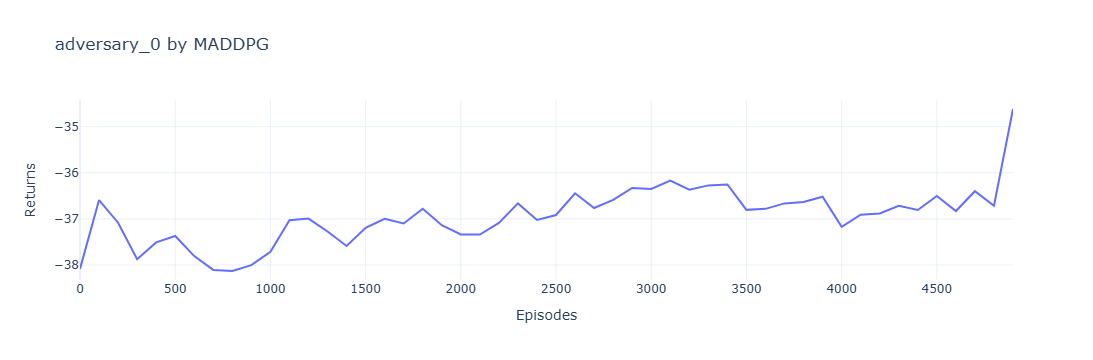

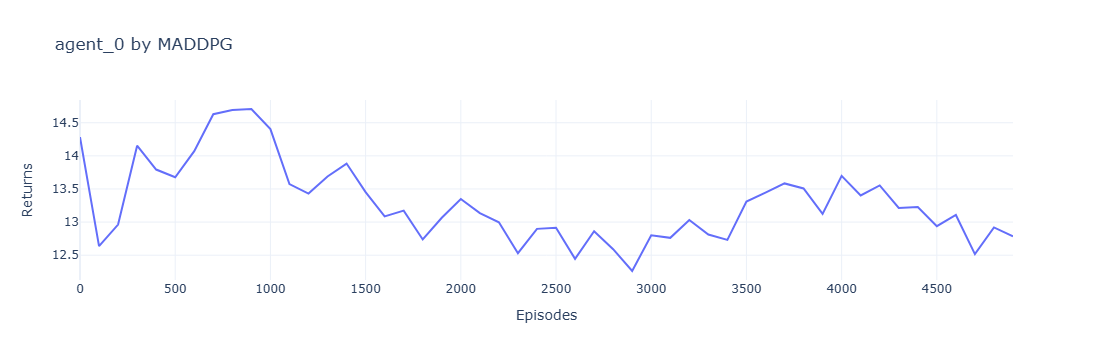

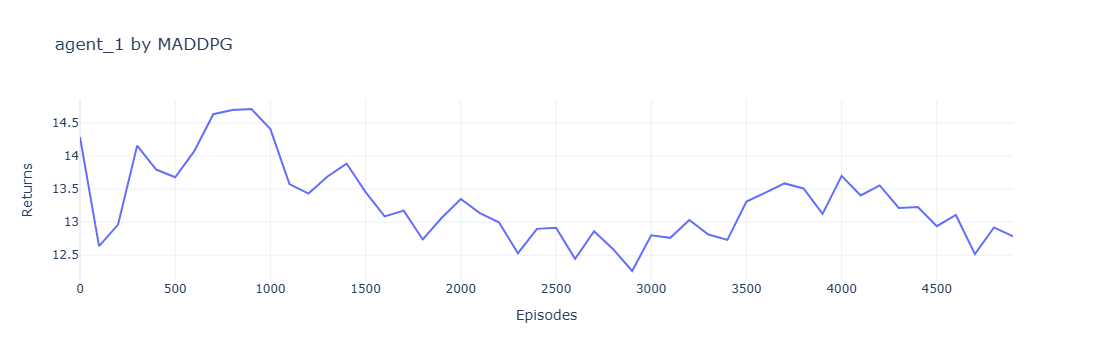

In [2]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from utils.smoothing import moving_average
# 从CSV文件读取数据
loaded_data = pd.read_csv('MADDPG_returns_data.csv', header=None).values
# 使用Plotly绘图
agents = ["adversary_0", "agent_0", "agent_1"]

for i, agent_name in enumerate(agents):
    # 计算x轴数据（每100个episode一个点）
    x_data = np.arange(loaded_data.shape[0]) * 100
    y_data = moving_average(loaded_data[:, i], 9)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x_data,
        y=y_data,
        mode='lines',
        name=agent_name,
        line=dict(width=2)
    ))
    fig.update_layout(
        title=f"{agent_name} by MADDPG",
        xaxis_title="Episodes",
        yaxis_title="Returns",
        hovermode="x unified",
        template="plotly_white"
    )
    
    fig.show()
    

# 待解决问题：
- 智能体在训练过程和评估当中会否会失活？
- 返回的各个字典，会直接缺失某个字段吗？
- 所以，是否需要修改代码逻辑？